In [1]:
import copy
import gc
import multiprocessing
import sys
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool

import anndata
import celltypist
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scipy.sparse as scs
from adjustText import adjust_text
from celltypist import models
from tqdm import tqdm

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-p

In [2]:
meta_data=pd.read_csv('/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/meta_data_GEO.csv')


In [3]:
adata=sc.read_h5ad("/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/TEA_scRNA.h5ad")
adata=adata.raw.to_adata()

In [4]:
barcodes_matching=pd.read_csv("/home/workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/barcodes_matching.csv")
barcodes_matching=barcodes_matching[barcodes_matching['AIFI_L3'].isin(['Core naive CD4 T cell',
                                              'CM CD4 T cell',
                                              'GZMB- CD27+ EM CD4 T cell',
                                              'GZMB- CD27- EM CD4 T cell',
                                              'KLRF1- GZMB+ CD27- memory CD4 T cell'])]

In [5]:
adata_subset=adata[adata.obs['AIFI_L3'].isin(['Core naive CD4 T cell',
                                              'CM CD4 T cell',
                                              'GZMB- CD27+ EM CD4 T cell',
                                              'GZMB- CD27- EM CD4 T cell',
                                              'KLRF1- GZMB+ CD27- memory CD4 T cell'])]

In [6]:
adata_subset=adata_subset[barcodes_matching['barcodes_scRNA'],]

In [7]:
adata_subset.raw=adata_subset
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)

In [8]:
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [9]:
%%time
sc.pp.scale(adata_subset)
sc.tl.pca(adata_subset,
          svd_solver='arpack')
sce.pp.harmony_integrate(adata_subset,
                         'batch_id',
                         max_iter_harmony = 20)
sc.pp.neighbors(adata_subset,
                n_neighbors=50,
                use_rep='X_pca_harmony',
                n_pcs=30)

2025-03-02 18:52:06,791 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-03-02 18:52:15,189 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-03-02 18:52:15,745 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2025-03-02 18:52:55,675 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2025-03-02 18:53:35,245 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2025-03-02 18:54:05,731 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2025-03-02 18:54:20,000 - harmonypy - INFO - Iteration 5 of 20
Iteration 5 of 20
2025-03-02 18:54:32,525 - harmonypy - INFO - Iteration 6 of 20
Iteration 6 of 20
2025-03-02 18:54:44,881 - harmonypy - INFO - Iteration 7 of 20
Iteration 7 of 20
2025-03-02 18:54:57,033 - harmonypy - INFO - Converged after 7 iterations
Converged after 7 iterations


CPU times: user 57min 31s, sys: 31.9 s, total: 58min 3s
Wall time: 5min 26s


In [10]:
%%time
sc.tl.umap(adata_subset,
           min_dist=0.45,
           random_state=0)

CPU times: user 12min 11s, sys: 1.01 s, total: 12min 12s
Wall time: 2min 29s


In [11]:
df=adata_subset.obs
df=df.merge(meta_data, on='pbmc_sample_id',how='left')

In [12]:
df.index=df['barcodes'].tolist()
adata_subset.obs=df

In [13]:
adata_subset.obs["cohort"] = adata_subset.obs["subject_id.ch1"].apply(
    lambda x: "UP1" if "UP" in x else "BR2"
)

In [14]:
adata_subset = adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)
adata_subset.raw = adata_subset

In [15]:
sc.tl.leiden(adata_subset,
             key_added="leiden")

In [16]:
sc.tl.rank_genes_groups(adata_subset, "leiden", method="t-test")


... storing 'pbmc_sample_id' as categorical
... storing 'GEO_Accession' as categorical
... storing 'Batch' as categorical
... storing 'combined_sample_id' as categorical
... storing 'cell.type.ch1' as categorical
... storing 'race.ch1' as categorical
... storing 'Sex.ch1' as categorical
... storing 'subject_id.ch1' as categorical
... storing 'cohort' as categorical


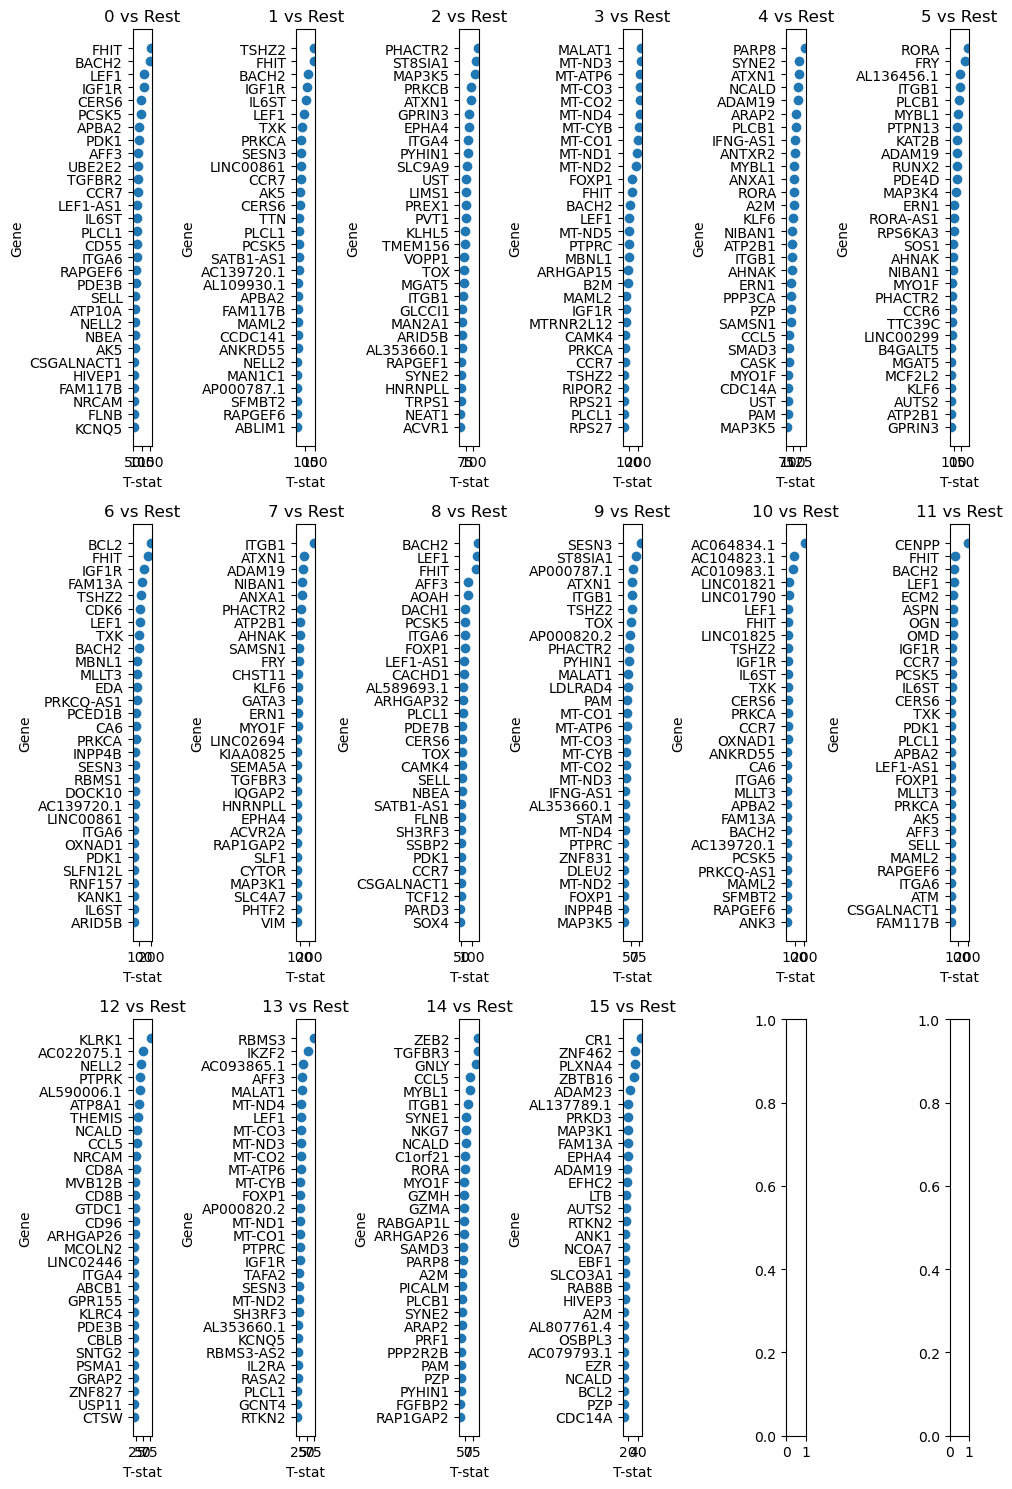

In [17]:
DEG_df = sc.get.rank_genes_groups_df(adata_subset, group=None)
DEG_df = DEG_df.groupby("group").head(30).reset_index(drop=True)
import matplotlib.pyplot as plt

groups = DEG_df.groupby("group")

fig, axs = plt.subplots(3, 6, figsize=(10, 15), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot

for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group["scores"], group["names"])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name) + " vs Rest")
    axs[row, col].set_xlabel("T-stat")
    axs[row, col].set_ylabel("Gene")
fig.tight_layout()

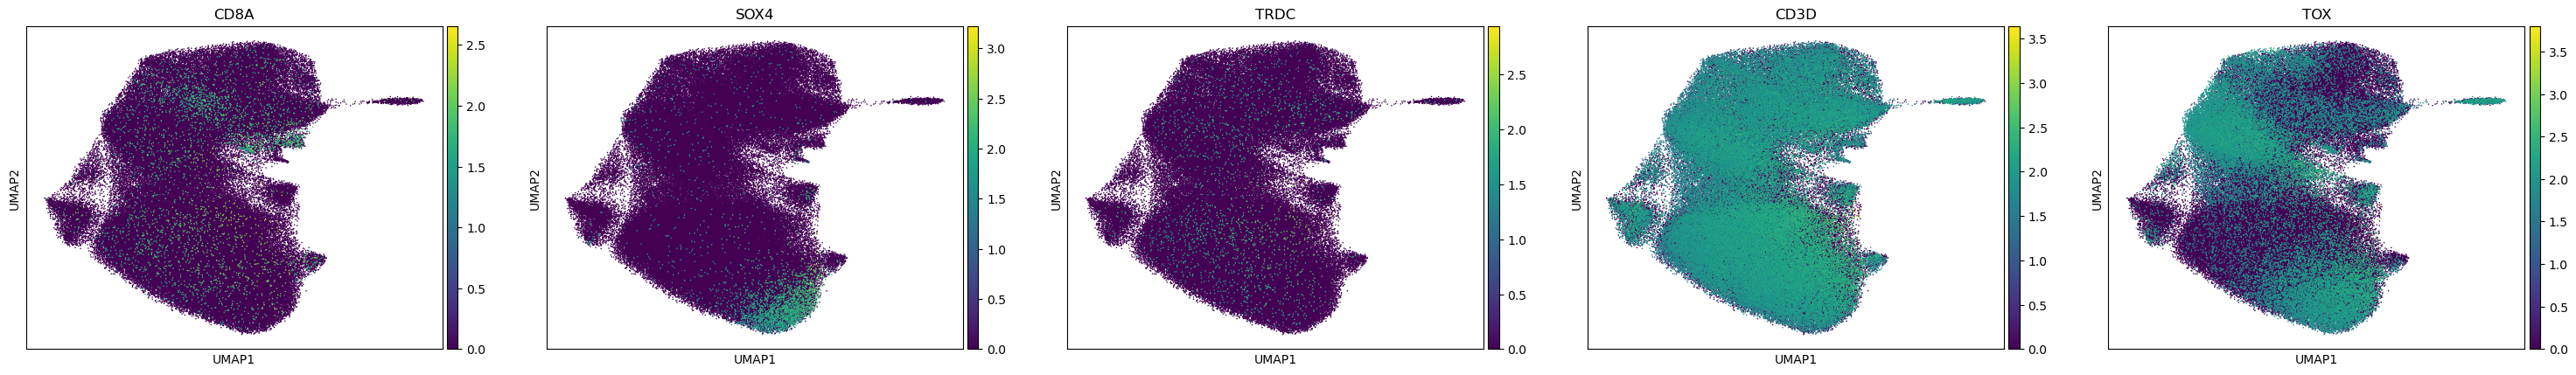

In [18]:
sc.pl.umap(adata_subset, color=["CD8A","SOX4","TRDC","CD3D","TOX"],size=5,use_raw=False,ncols=5)


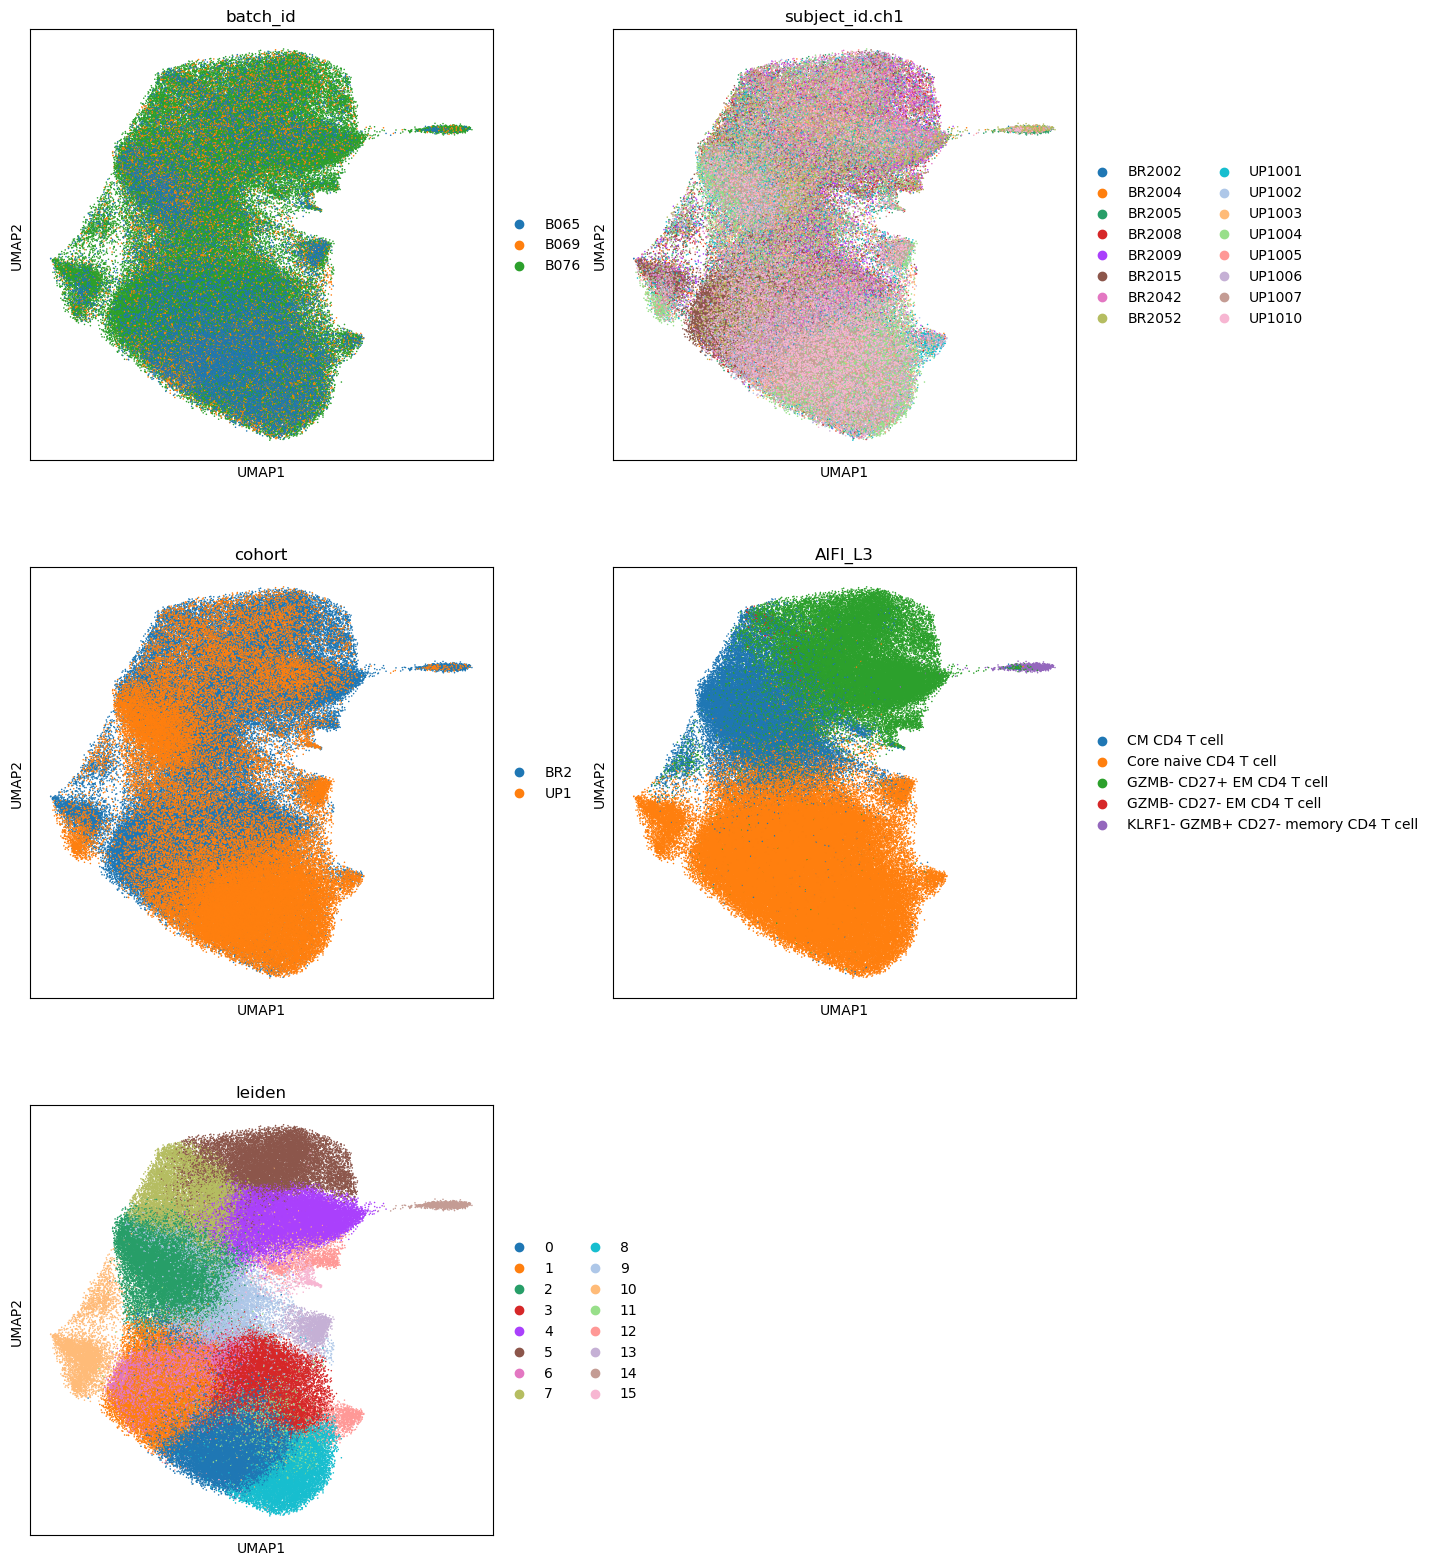

In [19]:
plt.rcParams["figure.figsize"] = [6, 6]


sc.pl.umap(
    adata_subset,
    color=["batch_id", "subject_id.ch1", "cohort", "AIFI_L3", "leiden"],
    size=5,
    use_raw=False,
    ncols=2,
)

In [20]:
adata_subset=adata_subset[~adata_subset.obs["leiden"].isin(["10","12",'13'])]

In [21]:
adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)

In [22]:
adata_subset.raw=adata_subset


In [23]:
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]
sc.pp.scale(adata_subset)
sc.tl.pca(adata_subset,
          svd_solver='arpack')
sce.pp.harmony_integrate(adata_subset,
                         'batch_id',
                         max_iter_harmony = 20)
sc.pp.neighbors(adata_subset,
                n_neighbors=50,
                use_rep='X_pca_harmony',
                n_pcs=30)

2025-03-02 19:07:05,276 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-03-02 19:07:13,250 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-03-02 19:07:13,766 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2025-03-02 19:07:51,070 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2025-03-02 19:08:27,888 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2025-03-02 19:09:01,200 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2025-03-02 19:09:15,886 - harmonypy - INFO - Iteration 5 of 20
Iteration 5 of 20
2025-03-02 19:09:27,302 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [24]:
sc.tl.umap(adata_subset,
           min_dist=0.45,
           random_state=0)


In [25]:
sc.tl.leiden(adata_subset,
             key_added="leiden")


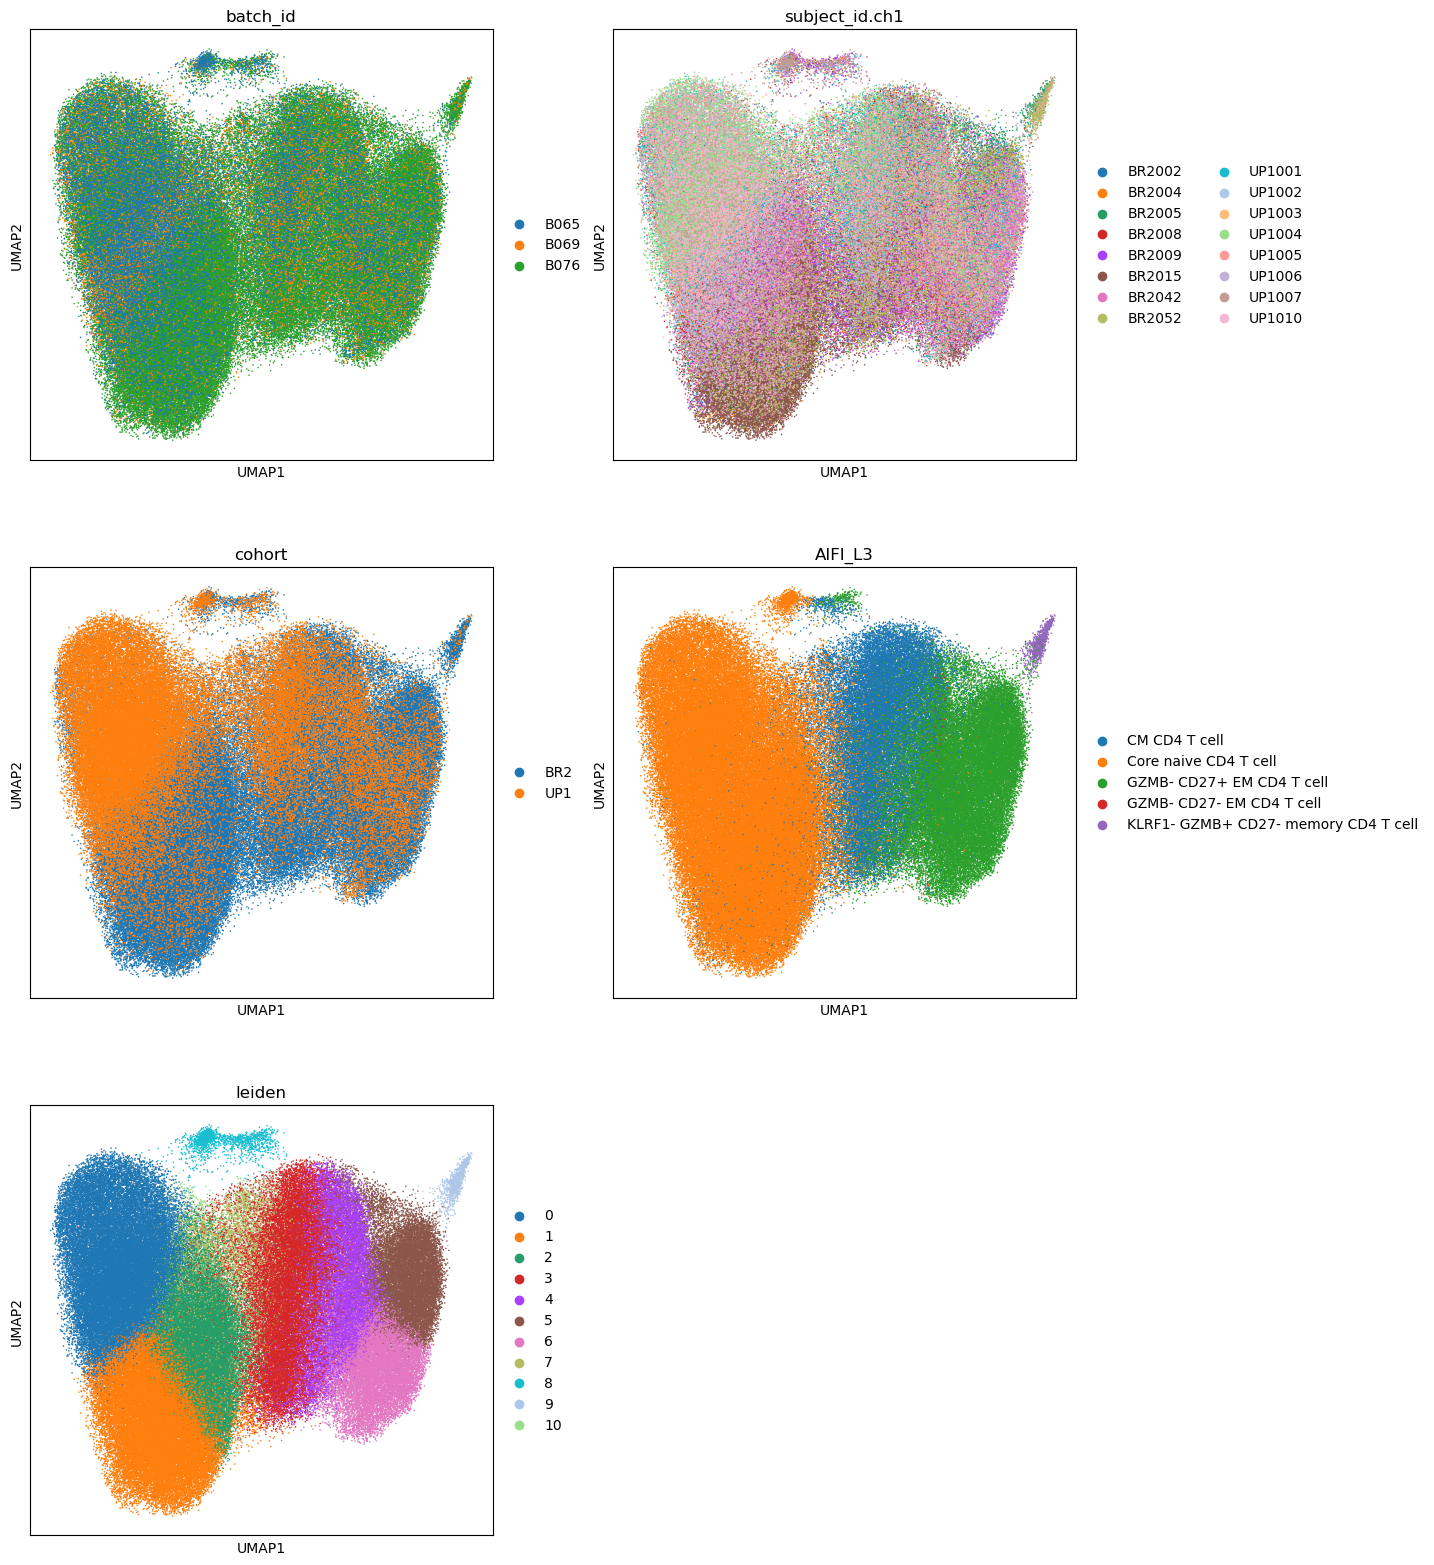

In [26]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["batch_id", 'subject_id.ch1',"cohort",'AIFI_L3',"leiden"],size=5,use_raw=False,ncols=2)

In [27]:
sc.tl.rank_genes_groups(adata_subset, "leiden", method="t-test")


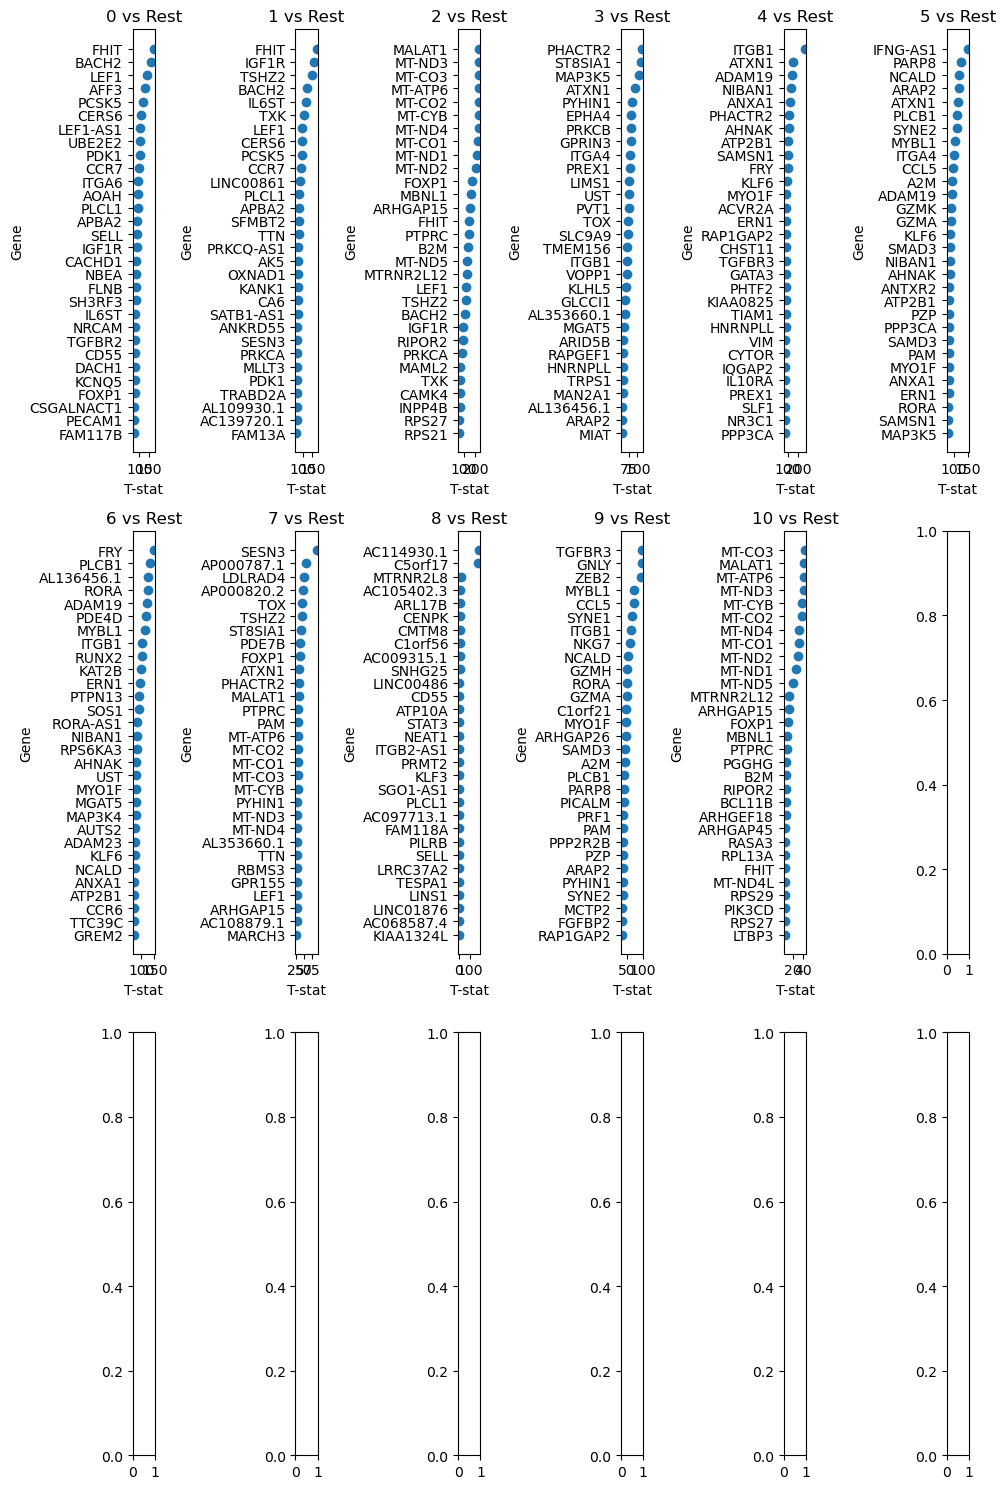

In [28]:
DEG_df=sc.get.rank_genes_groups_df(adata_subset,group=None)
DEG_df=DEG_df.groupby('group').head(30).reset_index(drop=True)
import matplotlib.pyplot as plt

groups = DEG_df.groupby('group')

fig, axs = plt.subplots(3, 6, figsize=(10, 15), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot

for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group['scores'], group['names'])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name)+" vs Rest")
    axs[row, col].set_xlabel('T-stat')
    axs[row, col].set_ylabel('Gene')
fig.tight_layout()

In [29]:
adata_subset=adata_subset[~adata_subset.obs["leiden"].isin(["8"])]

In [30]:
adata_subset=adata_subset.raw.to_adata()


In [31]:
adata_subset.write_h5ad('CD4T_Intermediate.h5ad')

In [20]:
adata_subset=sc.read_h5ad('CD4T_Intermediate.h5ad')

In [21]:
del adata_subset.obsm

In [22]:
#adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)

In [23]:
adata_subset.raw=adata_subset


In [24]:
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]
sc.pp.scale(adata_subset)
sc.tl.pca(adata_subset,
          svd_solver='arpack')
sce.pp.harmony_integrate(adata_subset,
                         'batch_id',
                         max_iter_harmony = 20)
sc.pp.neighbors(adata_subset,
                n_neighbors=50,
                use_rep='X_pca_harmony',
                n_pcs=25)

2025-03-04 11:15:28,745 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-03-04 11:15:37,486 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-03-04 11:15:38,007 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2025-03-04 11:16:16,820 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2025-03-04 11:16:54,919 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2025-03-04 11:17:30,917 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2025-03-04 11:17:46,399 - harmonypy - INFO - Iteration 5 of 20
Iteration 5 of 20
2025-03-04 11:17:58,461 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [25]:
sc.tl.umap(adata_subset ,
min_dist=0.45,
           random_state=0)

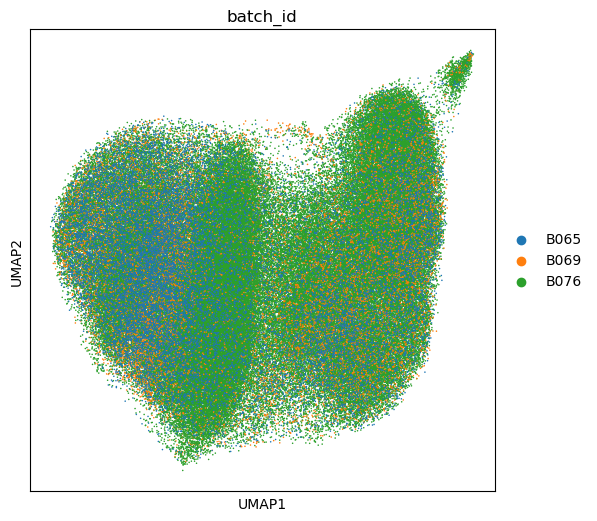

In [26]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["batch_id"],size=5,use_raw=False,ncols=2)

In [27]:
sc.tl.leiden(adata_subset,
             key_added="leiden")


... storing 'AIFI_L3' as categorical
... storing 'celltype_new' as categorical


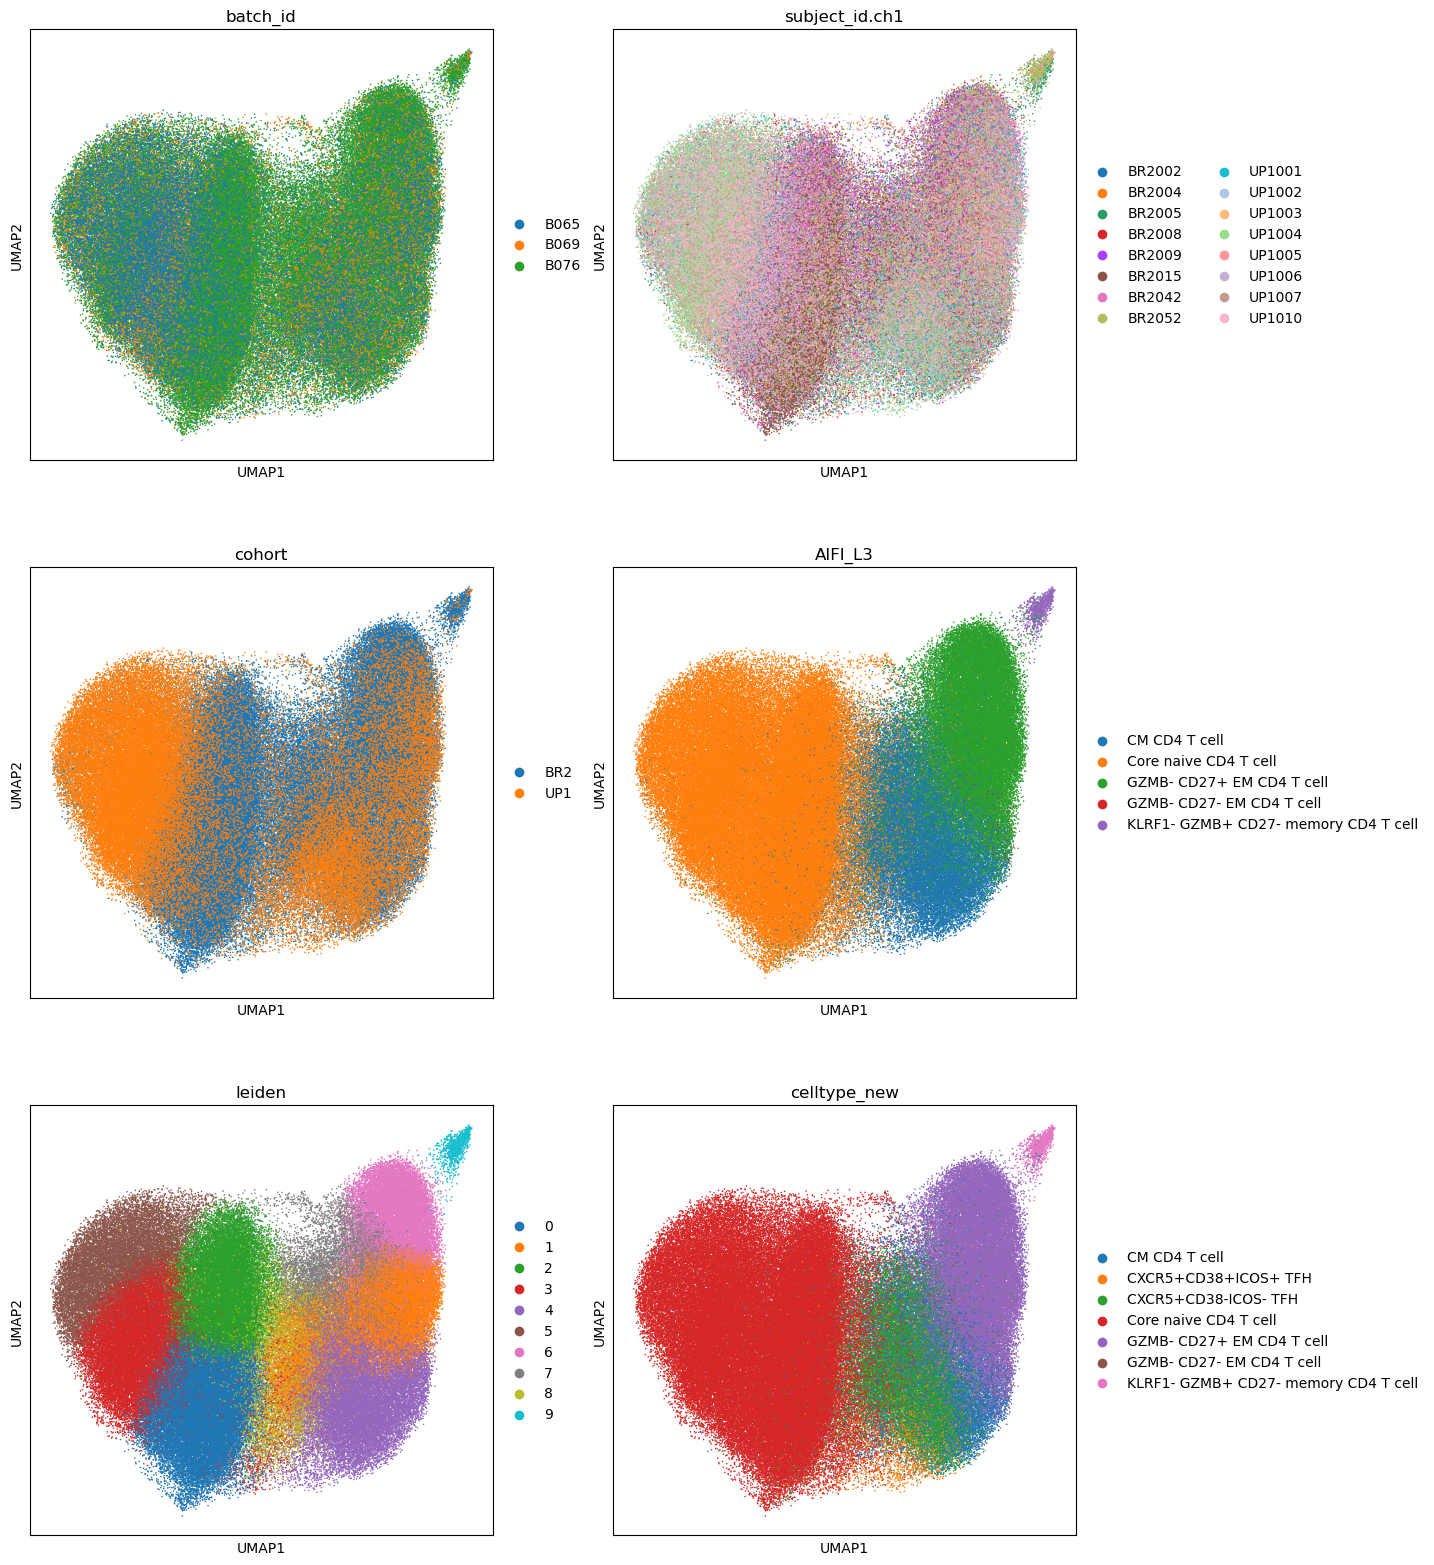

In [41]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["batch_id", 'subject_id.ch1',"cohort",'AIFI_L3',"leiden","celltype_new"],size=5,use_raw=False,ncols=2)

In [29]:
sc.tl.rank_genes_groups(adata_subset, "leiden", method="t-test")


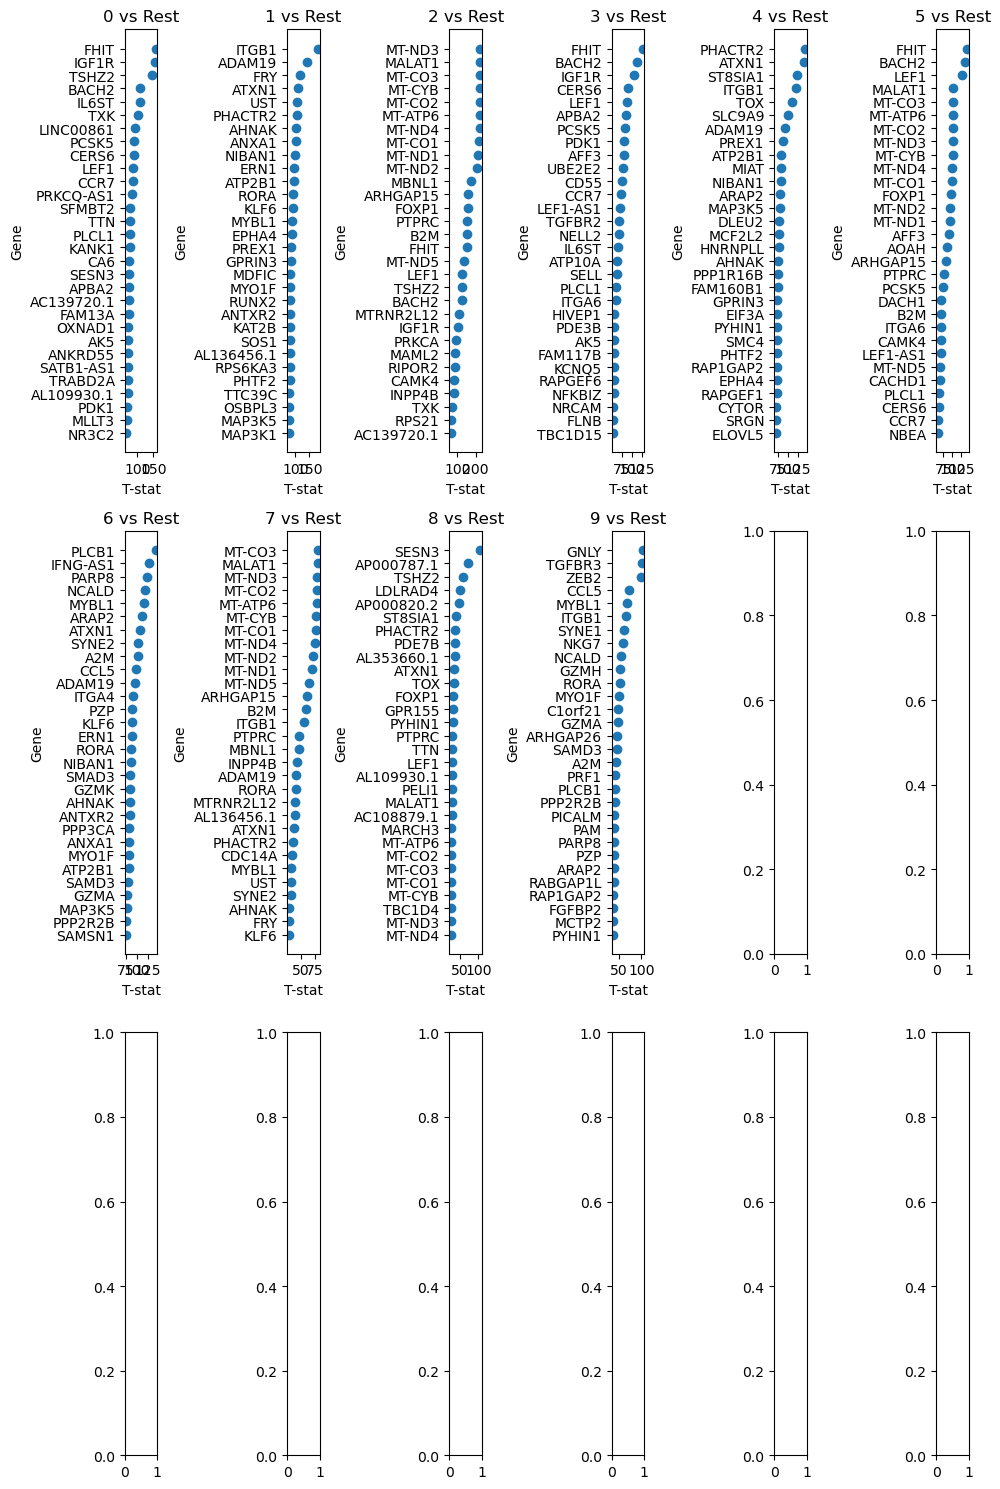

In [30]:
DEG_df=sc.get.rank_genes_groups_df(adata_subset,group=None)
DEG_df=DEG_df.groupby('group').head(30).reset_index(drop=True)
import matplotlib.pyplot as plt

groups = DEG_df.groupby('group')

fig, axs = plt.subplots(3, 6, figsize=(10, 15), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot

for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group['scores'], group['names'])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name)+" vs Rest")
    axs[row, col].set_xlabel('T-stat')
    axs[row, col].set_ylabel('Gene')
fig.tight_layout()


In [31]:
Tfh_annotation=sc.read_h5ad('/home/workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/Tfh_Clusterd.h5ad')

In [32]:
Tfh_annotation.obs[["barcodes","celltype_new"]]

barcodes  \
7666bdaae84e11eb9b9242010a19c839  7666bdaae84e11eb9b9242010a19c839   
4a6e5742e40911eba29d42010a19c839  4a6e5742e40911eba29d42010a19c839   
f502a6ece84e11eb806a42010a19c839  f502a6ece84e11eb806a42010a19c839   
03ab4bb8e84f11eb9b6342010a19c839  03ab4bb8e84f11eb9b6342010a19c839   
52496206e84e11eb964d42010a19c839  52496206e84e11eb964d42010a19c839   
...                                                            ...   
024d26a6e84f11eb9b6342010a19c839  024d26a6e84f11eb9b6342010a19c839   
5411ccace40911eba29d42010a19c839  5411ccace40911eba29d42010a19c839   
e87a6ebee84e11ebbb6c42010a19c839  e87a6ebee84e11ebbb6c42010a19c839   
40a039e2e40911eb9cd142010a19c839  40a039e2e40911eb9cd142010a19c839   
2130efe8e40911eb903842010a19c839  2130efe8e40911eb903842010a19c839   

                                               celltype_new  
7666bdaae84e11eb9b9242010a19c839              CM CD4 T cell  
4a6e5742e40911eba29d42010a19c839       CXCR5+CD38-ICOS- TFH  
f502a6ece84e11eb806a42010a19c839              CM CD4 T cell  
03ab4bb8e84f11eb9b6342010a19c839       CXCR5+CD38-ICOS- TFH  
52496206e84e11eb964d42010a19c839  GZMB- CD27+ EM CD4 T cell  
...                                                     ...  
024d26a6e84f11eb9b6342010a19c839  GZMB- CD27+ EM CD4 T cell  
5411ccace40911eba29d42010a19c839  GZMB- CD27+ EM CD4 T cell  
e87a6ebee84e11ebbb6c42010a19c839       CXCR5+CD38-ICOS- TFH  
40a039e2e40911eb9cd142010a19c839  GZMB- CD27+ EM CD4 T cell  
2130efe8e40911eb903842010a19c839  GZMB- CD27+ EM CD4 T cell  

[73154 rows x 2 columns]

In [33]:
df=pd.merge(adata_subset.obs,Tfh_annotation.obs[["barcodes","celltype_new"]],how="left")

In [34]:
df.index=df['barcodes'].tolist()

In [35]:
adata_subset.obs=df

In [36]:
adata_subset.obs['celltype_new'] =adata_subset.obs['celltype_new'].astype(str).replace('nan', None)  # Convert to string, keeping NaNs
adata_subset.obs['AIFI_L3'] = adata_subset.obs['AIFI_L3'].astype(str)

In [37]:
adata_subset.obs['celltype_new'] = adata_subset.obs['celltype_new'].fillna(adata_subset.obs['AIFI_L3'])


In [38]:
umap=pd.DataFrame(adata_subset.obsm['X_umap'])

In [39]:
adata_subset.obs["UMAP_1"]=umap[0].tolist()
adata_subset.obs["UMAP_2"]=umap[1].tolist()

In [40]:
adata_subset.obs.to_csv("scRNA_obs.csv")